In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define the DNN model
class DNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the Q-learning agent
class QLearningAgent:
    def __init__(self, state_space, action_space, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.995):
        self.state_space = state_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.q_table = np.zeros((state_space, action_space))  # Initialize Q-table
    
    def get_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice(range(self.action_space))  # Exploration
        else:
            return np.argmax(self.q_table[state])  # Exploitation
    
    def update_q_table(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        self.q_table[state, action] += self.learning_rate * (reward + self.discount_factor * self.q_table[next_state, best_next_action] - self.q_table[state, action])
    
    def decay_exploration(self):
        self.exploration_rate *= self.exploration_decay

# Function to detect concept drift using KS test
def detect_drift_ks(X_train, X_test, threshold=0.05):
    drift_detected = False
    for i in range(X_train.shape[1]):  # For each feature
        _, p_value = ks_2samp(X_train[:, i], X_test[:, i])  # KS test
        if p_value < threshold:  # If p-value is below threshold, drift is detected
            drift_detected = True
    return drift_detected

# Function to monitor accuracy
def monitor_accuracy(model, X_test, y_test):
    model.eval()
    predictions = torch.argmax(model(torch.tensor(X_test, dtype=torch.float32)), dim=1).numpy()
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

# Function to plot the ROC curve
def plot_roc_curve(model, X_test, y_test):
    model.eval()
    y_pred = torch.argmax(model(torch.tensor(X_test, dtype=torch.float32)), dim=1).numpy()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot training loss
def plot_performance(performance_history):
    plt.plot(performance_history)
    plt.title('Training Loss over Episodes')
    plt.xlabel('Episodes')
    plt.ylabel('Loss')
    plt.show()

# Training loop with drift detection and adaptation
def train_with_drift_detection(agent, model, X_train, y_train, X_test, y_test, n_episodes=200, batch_size=32, accuracy_threshold=0.2, ks_threshold=0.05):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    performance_history = []
    prev_accuracy = 0.0
    
    for episode in range(n_episodes):
        # Randomly pick a batch
        state = random.randint(0, len(X_train) - batch_size)
        batch_X = X_train[state:state+batch_size]
        batch_y = y_train[state:state+batch_size]
        
        # Model predictions
        model.train()
        outputs = model(torch.tensor(batch_X, dtype=torch.float32))
        loss = criterion(outputs, torch.tensor(batch_y, dtype=torch.long))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Monitor accuracy
        accuracy = monitor_accuracy(model, X_test, y_test)
        
        # Get action from agent
        action = agent.get_action(episode)  # Get action based on current episode as state
        
        # Check for drift based on KS test and accuracy dip
        drift_detected = detect_drift_ks(X_train, X_test, ks_threshold)
        accuracy_dip = accuracy < accuracy_threshold and accuracy < prev_accuracy  # Accuracy has dropped
        
        if drift_detected and accuracy_dip:
            print(f"Concept Drift detected at episode {episode}, applying penalty...")
            agent.update_q_table(state, action, -1, state)  # Penalize for drift
            model = DNNModel(input_size=X_train.shape[1], hidden_size=50, output_size=2)  # Reset model
            optimizer = optim.Adam(model.parameters(), lr=0.001)  # Reinitialize optimizer
        else:
            agent.update_q_table(state, action, 1, state)  # Reward for adaptation
        
        # Decay exploration
        agent.decay_exploration()

        performance_history.append(loss.item())
        prev_accuracy = accuracy
    
    return performance_history

# Load and preprocess your dataset
df = pd.read_csv('linear_sudden_rotation_noise_and_redunce.csv')  # Replace with your file path

# Assuming the label is the last column and features are all others
X = df.iloc[:, :-1].values  # Features (x1, x2, x3, x4, x5)
y = df.iloc[:, -1].values   # Label (binary: 0 or 1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize model and agent
model = DNNModel(input_size=X_train.shape[1], hidden_size=50, output_size=2)
agent = QLearningAgent(state_space=len(X_train), action_space=2)

# Train with drift detection
performance_history = train_with_drift_detection(agent, model, X_train, y_train, X_test, y_test)

# Plot performance (Loss curve)
plot_performance(performance_history)

# ROC Curve
plot_roc_curve(model, X_test, y_test)


ModuleNotFoundError: No module named 'torch'

Concept Drift detected at episode 1, Loss: 0.6890880465507507 > 0.5
Concept Drift detected at episode 5, Loss: 0.6743083000183105 > 0.5
Concept Drift detected at episode 9, Loss: 0.6999338865280151 > 0.5
Concept Drift detected at episode 13, Loss: 0.7232453227043152 > 0.5
Concept Drift detected at episode 14, Loss: 0.6835924983024597 > 0.5
Concept Drift detected at episode 19, Loss: 0.7135519981384277 > 0.5
Concept Drift detected at episode 20, Loss: 0.725480318069458 > 0.5
Concept Drift detected at episode 21, Loss: 0.6330636739730835 > 0.5
Concept Drift detected at episode 22, Loss: 0.7666760683059692 > 0.5
Concept Drift detected at episode 23, Loss: 0.6855702996253967 > 0.5
Concept Drift detected at episode 26, Loss: 0.6732193231582642 > 0.5
Concept Drift detected at episode 27, Loss: 0.6789731383323669 > 0.5
Concept Drift detected at episode 28, Loss: 0.677972674369812 > 0.5
Concept Drift detected at episode 29, Loss: 0.6800678372383118 > 0.5
Concept Drift detected at episode 31, L

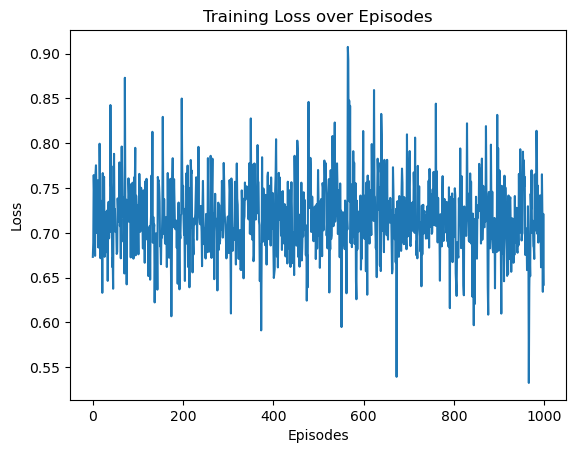

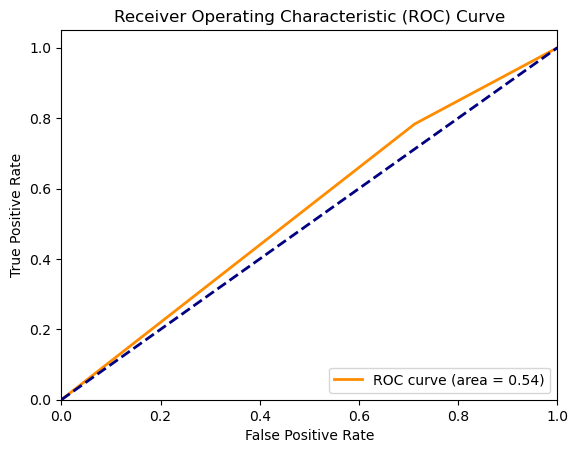

Drift detected at episodes: [1, 5, 9, 13, 14, 19, 20, 21, 22, 23, 26, 27, 28, 29, 31, 32, 33, 38, 44, 45, 50, 51, 52, 53, 54, 56, 58, 59, 61, 62, 69, 70, 74, 75, 76, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 100, 101, 105, 106, 110, 111, 112, 115, 116, 117, 118, 119, 120, 123, 124, 125, 126, 127, 128, 129, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 150, 151, 153, 154, 157, 161, 163, 164, 169, 170, 172, 173, 174, 175, 177, 178, 184, 185, 188, 189, 190, 191, 192, 193, 194, 199, 203, 204, 205, 206, 209, 214, 222, 225, 226, 227, 233, 239, 241, 242, 246, 249, 251, 252, 253, 254, 255, 256, 258, 259, 260, 262, 263, 264, 265, 266, 267, 268, 269, 272, 273, 274, 275, 276, 277, 278, 279, 282, 283, 284, 285, 288, 296, 297, 299, 300, 301, 302, 304, 305, 306, 310, 312, 313, 316, 317, 318, 324, 325, 326, 327, 328, 329, 331, 333, 334, 340, 342, 343, 346, 349, 355, 356, 357, 361, 362, 364, 370, 372, 373, 374, 375, 376, 379, 383, 386, 388, 390, 393, 397, 398, 399, 400, 401, 402, 403, 410, 4

In [20]:
# DDM 
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define the DNN model
class DNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the Q-learning agent
class QLearningAgent:
    def __init__(self, state_space, action_space, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.995):
        self.state_space = state_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.q_table = np.zeros((state_space, action_space))  # Initialize Q-table
    
    def get_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice(range(self.action_space))  # Exploration
        else:
            return np.argmax(self.q_table[state])  # Exploitation
    
    def update_q_table(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        self.q_table[state, action] += self.learning_rate * (reward + self.discount_factor * self.q_table[next_state, best_next_action] - self.q_table[state, action])
    
    def decay_exploration(self):
        self.exploration_rate *= self.exploration_decay

# DDM Class for Drift Detection
class DDM:
    def __init__(self, error_threshold=0.05):
        self.error_threshold = error_threshold
        self.mean_error = 0.0
        self.std_error = 0.0
        self.error_count = 0
        self.drift_detected = False
    
    def update(self, error_rate):
        self.error_count += 1
        
        # Update mean and standard deviation of errors
        if self.error_count == 1:
            self.mean_error = error_rate
            self.std_error = 0.0  # First error, std is 0
        else:
            delta = error_rate - self.mean_error
            self.mean_error += delta / self.error_count
            self.std_error += delta * (error_rate - self.mean_error)
        
        # Standard deviation is the square root of the accumulated squared deviations
        if self.error_count > 1:
            self.std_error = np.sqrt(self.std_error / (self.error_count - 1))
        
        # Check if the error rate exceeds the threshold
        if self.std_error > 0 and error_rate > self.mean_error + self.error_threshold * self.std_error:
            self.drift_detected = True
        else:
            self.drift_detected = False
        
        return self.drift_detected

# Function to monitor accuracy
def monitor_accuracy(model, X_test, y_test):
    model.eval()
    predictions = torch.argmax(model(torch.tensor(X_test, dtype=torch.float32)), dim=1).numpy()
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

# Function to plot the ROC curve
def plot_roc_curve(model, X_test, y_test):
    model.eval()
    y_pred = torch.argmax(model(torch.tensor(X_test, dtype=torch.float32)), dim=1).numpy()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot training loss
def plot_performance(performance_history):
    plt.plot(performance_history)
    plt.title('Training Loss over Episodes')
    plt.xlabel('Episodes')
    plt.ylabel('Loss')
    plt.show()

# Training loop with drift detection and adaptation
def train_with_drift_detection(agent, model, X_train, y_train, X_test, y_test, n_episodes=1000, batch_size=32, loss_threshold=0.5):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    performance_history = []
    prev_accuracy = 0.0
    drift_points = []  # To store drift points
    
    # Initialize DDM
    ddm = DDM()

    for episode in range(n_episodes):
        # Randomly pick a batch
        state = random.randint(0, len(X_train) - batch_size)
        batch_X = X_train[state:state+batch_size]
        batch_y = y_train[state:state+batch_size]
        
        # Model predictions
        model.train()
        outputs = model(torch.tensor(batch_X, dtype=torch.float32))
        loss = criterion(outputs, torch.tensor(batch_y, dtype=torch.long))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Monitor accuracy
        accuracy = monitor_accuracy(model, X_test, y_test)
        
        # Check if loss exceeds threshold and if drift is detected
        if loss.item() > loss_threshold:
            drift_detected = ddm.update(accuracy)  # Use accuracy as the error rate for DDM
            
            if drift_detected:
                print(f"Concept Drift detected at episode {episode}, Loss: {loss.item()} > {loss_threshold}")
                drift_points.append(episode)  # Mark drift point
                # Apply penalty by resetting the model
                model = DNNModel(input_size=X_train.shape[1], hidden_size=200, output_size=2)  # Reset model
                optimizer = optim.Adam(model.parameters(), lr=0.001)  # Reinitialize optimizer
                agent.update_q_table(state, agent.get_action(episode), -1, state)  # Penalize for drift
            else:
                agent.update_q_table(state, agent.get_action(episode), 1, state)  # Reward for adaptation
        else:
            agent.update_q_table(state, agent.get_action(episode), 1, state)  # Reward for continued training
        
        # Decay exploration
        agent.decay_exploration()

        performance_history.append(loss.item())
        prev_accuracy = accuracy
    
    return performance_history, drift_points

# Load and preprocess your dataset
df = pd.read_csv('linear_sudden_rotation_noise_and_redunce.csv')  # Replace with your file path

# Assuming the label is the last column and features are all others
X = df.iloc[:, :-1].values  # Features (x1, x2, x3, x4, x5)
y = df.iloc[:, -1].values   # Label (binary: 0 or 1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize model and agent
model = DNNModel(input_size=X_train.shape[1], hidden_size=50, output_size=2)
# Initialize model and agent
model = DNNModel(input_size=X_train.shape[1], hidden_size=50, output_size=2)
agent = QLearningAgent(state_space=len(X_train), action_space=2)

# Train with drift detection
performance_history, drift_points = train_with_drift_detection(agent, model, X_train, y_train, X_test, y_test)

# Plot performance (Loss curve)
plot_performance(performance_history)

# ROC Curve
plot_roc_curve(model, X_test, y_test)

# Print drift points
print(f"Drift detected at episodes: {drift_points}")

In [19]:
import numpy as np
temp = np.array([[0,1,3,4],[0,1,3,6],[0,1,8,4]])

In [21]:
np.argmax(temp[1])

3